# Определение перспективного тарифа для телеком-компании

Описание проекта:

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Цель проекта:**

* Проанализировать поведение клиентов и сделать вывод — какой тариф лучше;
* Проверить гипотезы:
    1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
    2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


### Шаг 1. 
### Открыть файл с данными и изучить общую информацию

In [1]:
# Импортируем необходимые для работы библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import math
from scipy import stats as st

In [2]:
# Прочитаем файлы с данными

try:
    calls = pd.read_csv('calls.csv')
    internet = pd.read_csv('internet.csv')
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')
    users = pd.read_csv('users.csv')
    
except FileNotFoundError:
    
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')

    

In [3]:
# просмотрим состав данных
display(calls.head())
display(internet.head())
display(messages.head())
display(tariffs.head())
users.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
calls.info()
internet.info()
messages.info()
tariffs.info()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 co

Перейдем к подготовке данных к анализу.

### Шаг 2. 
### Подготовить данные

Приведем данные к нужным типам, проверим на явные и неявные дубликаты. Проверим разброс численных значений, проверим на аномалии.

In [5]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d', errors='ignore')                                       # приведем столбцы к типу дата
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d', errors='ignore')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d', errors='ignore')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d', errors='ignore')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d', errors='ignore')

In [6]:
print(calls.call_date.agg(['min','max']).apply('{:%d %B %Y}'.format))
print(internet.session_date.agg(['min','max']).apply('{:%d %B %Y}'.format))
print(messages.message_date.agg(['min','max']).apply('{:%d %B %Y}'.format))

min     01 January 2018
max    31 December 2018
Name: call_date, dtype: object
min     01 January 2018
max    31 December 2018
Name: session_date, dtype: object
min     02 January 2018
max    31 December 2018
Name: message_date, dtype: object


In [7]:
internet = internet.drop(['Unnamed: 0'], axis=1) # удалим лишний столбец

In [8]:
for i in (calls, internet, users):
    display(i.drop(['user_id'], axis=1).describe())

,duration
count,202607.000000
mean,6.755887
std,5.843365
min,0.000000
25%,1.300000
50%,6.000000
75%,10.700000
max,38.000000


,mb_used
count,149396.000000
mean,370.192426
std,278.300951
min,0.000000
25%,138.187500
50%,348.015000
75%,559.552500
max,1724.830000


,age
count,500.00000
mean,46.58800
std,16.66763
min,18.00000
25%,32.00000
50%,46.00000
75%,62.00000
max,75.00000


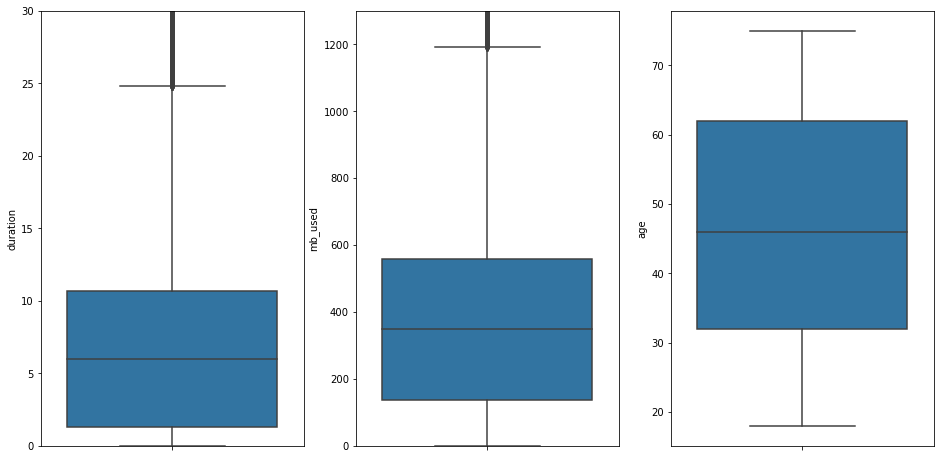

In [9]:
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 3, 1)
sns.boxplot(data=calls, y='duration')
plt.ylim(top = 30, bottom = 0)
ax2 = plt.subplot(1, 3, 2)
sns.boxplot(data=internet, y='mb_used')
plt.ylim(top = 1300, bottom = 0)
ax3 = plt.subplot(1, 3, 3)
sns.boxplot(data=users, y='age')
plt.show()

Итак основная часть разговоров длится менее 25 минут, разговоры, длящиеся более 25 минут являются аномалиями. Сессии в основном не превышают 1200 Мб. Минимальный возраст пользователей 18 лет, максимальный - 75. 75 % пользователей не старше 62 лет. Исключать аномалии мы не будем, т.к. они не дают оснований полагать, что в данных ошибки, предположим, что некоторые пользователи любят поговорить, и сидеть в интернете. Просто будем иметь это ввиду.

In [10]:
users['user_id'] = users['user_id'].astype(object)       # приведем столбцы с уникальными номерами пользователй к типу object
messages['user_id'] = messages['user_id'].astype(object)
internet['user_id'] = internet['user_id'].astype(object)
calls['user_id'] = calls['user_id'].astype(object)

Изучим содержание столбцов, пропуски и дубликаты.

In [11]:
def unique(row):
    return print(row.sort_values().unique())

In [12]:
# Просмотрим уникальные значения столбцов таблицы `users`
(
    users
    .drop(['user_id','age','churn_date', 'reg_date'], axis=1)
    .apply(unique)
) # исключим значения столбцов с количественными переменными

['Архангельск' 'Астрахань' 'Балашиха' 'Барнаул' 'Белгород' 'Брянск'
 'Владивосток' 'Владикавказ' 'Владимир' 'Волгоград' 'Волжский' 'Вологда'
 'Воронеж' 'Грозный' 'Екатеринбург' 'Иваново' 'Ижевск' 'Иркутск' 'Казань'
 'Калининград' 'Калуга' 'Кемерово' 'Киров' 'Кострома' 'Краснодар'
 'Красноярск' 'Курган' 'Курск' 'Липецк' 'Магнитогорск' 'Махачкала'
 'Москва' 'Мурманск' 'Набережные Челны' 'Нижневартовск' 'Нижний Новгород'
 'Нижний Тагил' 'Новокузнецк' 'Новороссийск' 'Новосибирск' 'Омск'
 'Оренбург' 'Орёл' 'Пенза' 'Пермь' 'Петрозаводск' 'Подольск'
 'Ростов-на-Дону' 'Рязань' 'Самара' 'Санкт-Петербург' 'Саранск' 'Саратов'
 'Севастополь' 'Смоленск' 'Сочи' 'Ставрополь' 'Стерлитамак' 'Сургут'
 'Тамбов' 'Тверь' 'Тольятти' 'Томск' 'Тула' 'Тюмень' 'Улан-Удэ'
 'Ульяновск' 'Уфа' 'Хабаровск' 'Химки' 'Чебоксары' 'Челябинск' 'Череповец'
 'Чита' 'Якутск' 'Ярославль']
['Авксентий' 'Агата' 'Агафья' 'Агнесса' 'Адам' 'Аким' 'Аксён' 'Алан'
 'Алевтина' 'Александр' 'Александра' 'Алексей' 'Алина' 'Алиса' 'Алла'


city          None
first_name    None
last_name     None
tariff        None
dtype: object

Неявных дубликатов не обнаружено

In [13]:
for i in (users, messages, internet, calls):
    
    print('Количество пропусков в таблице:')
    print(i.isna().sum())
    duplicated = i.duplicated().sum()
    print(f'Количество явных дубликатов в таблице - {duplicated}')

Количество пропусков в таблице:
user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64
Количество явных дубликатов в таблице - 0
Количество пропусков в таблице:
id              0
message_date    0
user_id         0
dtype: int64
Количество явных дубликатов в таблице - 0
Количество пропусков в таблице:
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64
Количество явных дубликатов в таблице - 0
Количество пропусков в таблице:
id           0
call_date    0
duration     0
user_id      0
dtype: int64
Количество явных дубликатов в таблице - 0


Пропуски в столбце `churn_date` таблицы `users` говорят о том, что если значение пропущено, то тариф ещё действовал на момент выгрузки данных, в противном случа столбец содержит дату прекращения действия тарифа.

**Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам.**

Для этого нам необходимо создать столбцы с месяцем, в котором происходили события.

In [14]:
messages['month'] = messages.message_date.dt.month
internet['month'] = internet.session_date.dt.month
calls['month'] = calls.call_date.dt.month

Для группировки совершенных звонков исключим звонки с нулевой длительностью, так как это входящие звонки.

In [15]:
calls

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


In [16]:
calls['round_duration'] = calls['duration']
calls['round_duration'] = calls['round_duration'].apply(lambda x: math.ceil(x))

In [17]:
calls

,id,call_date,duration,user_id,month,round_duration
0,1000_0,2018-07-25,0.00,1000,7,0
1,1000_1,2018-08-17,0.00,1000,8,0
2,1000_2,2018-06-11,2.85,1000,6,3
3,1000_3,2018-09-21,13.80,1000,9,14
4,1000_4,2018-12-15,5.18,1000,12,6
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12,1
202603,1499_216,2018-10-18,18.83,1499,10,19
202604,1499_217,2018-11-10,10.81,1499,11,11
202605,1499_218,2018-10-06,4.27,1499,10,5


In [18]:
calls_users = (
        calls.query('duration != 0')
        .groupby(['user_id','month'])
        .agg(
            {
                'id': 'count',
                'round_duration': 'sum'
            }
        )
        .rename(columns={'id': 'calls_cnt',
                        'round_duration': 'sum_duration'})
        .reset_index()
    )

In [19]:
calls_users

,user_id,month,calls_cnt,sum_duration
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
...,...,...,...,...
3163,1498,10,30,247
3164,1499,9,8,70
3165,1499,10,44,449
3166,1499,11,62,612


**Посчитаем количество отправленных сообщений по месяцам.**

In [20]:
messeges_users = (
        messages
        .groupby(['user_id','month'])
        .agg(
            {
                'id': 'count'
            }
        )
        .rename(columns={'id': 'message_cnt'})
        .reset_index()
    )

In [21]:
messeges_users

,user_id,month,message_cnt
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


**Найдем объем израсходованного интернет трафика по мессяцам для каждого пользователя.**

In [22]:
internet_users = (
        internet
        .groupby(['user_id','month'])
        .agg(
            {
                'mb_used': 'sum'
            }
        )
        .rename(columns={'mb_used': 'mb_sum'})
        .reset_index()
    )

In [23]:
internet_users['mb_sum'] = internet_users['mb_sum'].apply(lambda x: math.ceil(x))
internet_users

,user_id,month,mb_sum
0,1000,5,2254
1,1000,6,23234
2,1000,7,14004
3,1000,8,14056
4,1000,9,14569
...,...,...,...
3198,1498,10,20580
3199,1499,9,1846
3200,1499,10,17789
3201,1499,11,17964


**Расчитаем помесячную выручку с каждого пользователя.**

In [24]:
len(users['user_id'].unique())

500

In [25]:
len(users)

500

Всего в таблице `users` 500 строк, и количество уникальных клиентов так же 500, поэтому в выборке нет клиентов, которые переходили с одного тарифа на другой.

Объединим таблицы израсходованными минутами, мегабайтами, и смс каждого пользователя по месяцам, для того, чтобы найти общие доходы по каждому клиенту в соответствии с тарифами.

In [26]:
revenue_users = calls_users.merge(messeges_users, on=['user_id','month'], how = 'outer')
revenue_users = revenue_users.merge(internet_users, on=['user_id','month'], how = 'outer')
revenue_users = revenue_users.merge(users[['user_id','tariff']])

In [27]:
revenue_users

,user_id,month,calls_cnt,sum_duration,message_cnt,mb_sum,tariff
0,1000,5,17.0,159.0,22.0,2254.0,ultra
1,1000,6,28.0,172.0,60.0,23234.0,ultra
2,1000,7,41.0,340.0,75.0,14004.0,ultra
3,1000,8,42.0,408.0,81.0,14056.0,ultra
4,1000,9,46.0,466.0,57.0,14569.0,ultra
...,...,...,...,...,...,...,...
3209,1489,8,NaN,NaN,17.0,11051.0,smart
3210,1489,9,NaN,NaN,32.0,17207.0,smart
3211,1489,10,NaN,NaN,21.0,19560.0,smart
3212,1489,11,NaN,NaN,20.0,17492.0,smart


In [28]:
revenue_users = revenue_users.fillna(0)

In [29]:
for x in ('user_id','calls_cnt','sum_duration','message_cnt', 'mb_sum'):
    revenue_users[x] = revenue_users[x].astype(int)

In [30]:
revenue_users['user_id'] = revenue_users['user_id'].astype(object)

In [31]:
revenue_users

,user_id,month,calls_cnt,sum_duration,message_cnt,mb_sum,tariff
0,1000,5,17,159,22,2254,ultra
1,1000,6,28,172,60,23234,ultra
2,1000,7,41,340,75,14004,ultra
3,1000,8,42,408,81,14056,ultra
4,1000,9,46,466,57,14569,ultra
...,...,...,...,...,...,...,...
3209,1489,8,0,0,17,11051,smart
3210,1489,9,0,0,32,17207,smart
3211,1489,10,0,0,21,19560,smart
3212,1489,11,0,0,20,17492,smart


**Вычислим какую выручку принес каждый клиент в каждом месяце.**

Найдем количество минут, смс и мб интернета израсходованых сверх лимита.

In [32]:
def new_columns(column, limit, rub_per):
    
    def function_over_limit(row):                      
            if row['tariff'] == 'ultra':                          
                return row[column] - tariffs.loc[1, limit]
            if row['tariff'] == 'smart':       
                return row[column] - tariffs.loc[0, limit]

    revenue_users['over_limit'] = (
        revenue_users.
        apply(function_over_limit, axis = 1)
    )# применяем функцию к строкам датафрейма

    revenue_users.loc[revenue_users["over_limit"] < 0, "over_limit"] = 0
    
    if rub_per == 'rub_per_gb':
        revenue_users["over_limit"] = (revenue_users["over_limit"]/1024).apply(lambda x: math.ceil(x))
    else:
        pass
    
    def function_revenue(row):                      
            if row['tariff'] == 'ultra':                          
                return row['over_limit']*tariffs.loc[1, rub_per]      
            if row['tariff'] == 'smart':       
                return row['over_limit']*tariffs.loc[0, rub_per]
        
    revenue_users['revenue'] = revenue_users.apply(function_revenue, axis = 1)

In [33]:
new_columns('sum_duration', 'minutes_included', 'rub_per_minute')
revenue_users = revenue_users.rename(columns={'over_limit':'over_limit_call', 'revenue':'revenue_call'})

In [34]:
new_columns('message_cnt', 'messages_included', 'rub_per_message')
revenue_users = revenue_users.rename(columns={'over_limit':'over_limit_messages', 'revenue':'revenue_messages'})

In [35]:
new_columns('mb_sum', 'mb_per_month_included', 'rub_per_gb')
revenue_users = revenue_users.rename(columns={'over_limit':'over_limit_internet', 'revenue':'revenue_internet'})

In [36]:
revenue_users.query('over_limit_messages != 0')

,user_id,month,calls_cnt,sum_duration,message_cnt,mb_sum,tariff,over_limit_call,revenue_call,over_limit_messages,revenue_messages,over_limit_internet,revenue_internet
32,1005,3,63,606,56,11105,smart,106,318,6,18,0,0
36,1005,7,62,569,56,7695,smart,69,207,6,18,0,0
37,1005,8,64,619,64,7544,smart,119,357,14,42,0,0
38,1005,9,57,479,52,7017,smart,0,0,2,6,0,0
40,1005,11,60,547,51,12667,smart,47,141,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119,1490,7,29,250,62,10794,smart,0,0,12,36,0,0
3164,1496,12,65,518,51,20737,smart,18,54,1,3,6,1200
3169,1498,8,43,400,62,24236,smart,0,0,12,36,9,1800
3174,1499,11,62,612,59,17964,smart,112,336,9,27,3,600


In [37]:
def revenue_user(row):
    if row['tariff'] == 'ultra':
        return row['revenue_call'] + row['revenue_messages'] + row['revenue_internet'] + tariffs.loc[1, 'rub_monthly_fee']
    if row['tariff'] == 'smart':
        return row['revenue_call'] + row['revenue_messages'] + row['revenue_internet'] + tariffs.loc[0, 'rub_monthly_fee']

    
revenue_users['revenue_user'] = revenue_users.apply(revenue_user, axis = 1)

In [38]:
revenue_users

,user_id,month,calls_cnt,sum_duration,message_cnt,mb_sum,tariff,over_limit_call,revenue_call,over_limit_messages,revenue_messages,over_limit_internet,revenue_internet,revenue_user
0,1000,5,17,159,22,2254,ultra,0,0,0,0,0,0,1950
1,1000,6,28,172,60,23234,ultra,0,0,0,0,0,0,1950
2,1000,7,41,340,75,14004,ultra,0,0,0,0,0,0,1950
3,1000,8,42,408,81,14056,ultra,0,0,0,0,0,0,1950
4,1000,9,46,466,57,14569,ultra,0,0,0,0,0,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0,0,17,11051,smart,0,0,0,0,0,0,550
3210,1489,9,0,0,32,17207,smart,0,0,0,0,2,400,950
3211,1489,10,0,0,21,19560,smart,0,0,0,0,5,1000,1550
3212,1489,11,0,0,20,17492,smart,0,0,0,0,3,600,1150


### Шаг 3.
### Проанализировать данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Метрика разброса, представляющая собой средний квадрат расстояния между значениями датасета и средним, называется дисперсией. 

Если известно, что датасет — не вся совокупность, а выборка из неё, вместо дисперсии считают её оценку по имеющейся выборке (то есть s², а не σ²). Для этого в методе var() указывают параметр ddof=1. 

Найдем среднее значение, дисперсию и стандартное отклонение для значений расходуемых минут пользователями в месяц, отправленных смс и расходуемого интернет-трафика. Запишем результаты в таблицу.

In [39]:
#variance_call = np.var(revenue_users.query('sum_duration != 0')['sum_duration'], ddof=1)
#variance_message = np.var(revenue_users.query('message_cnt != 0')['message_cnt'], ddof=1)
#variance_internet = np.var(revenue_users.query('mb_sum != 0')['mb_sum'], ddof=1)

#standard_deviation_call = np.std(revenue_users.query('sum_duration != 0')['sum_duration'], ddof=1)
#standard_deviation_message = np.std(revenue_users.query('message_cnt != 0')['message_cnt'], ddof=1)
#standard_deviation_internet = np.std(revenue_users.query('mb_sum != 0')['mb_sum'], ddof=1)

#mean_call = revenue_users.query('sum_duration != 0')['sum_duration'].mean()
#mean_message = revenue_users.query('message_cnt != 0')['message_cnt'].mean()
#mean_internet = revenue_users.query('mb_sum != 0')['mb_sum'].mean()

In [40]:
variance_call = np.var(revenue_users['sum_duration'], ddof=1)
variance_message = np.var(revenue_users['message_cnt'], ddof=1)
variance_internet = np.var(revenue_users['mb_sum'], ddof=1)

standard_deviation_call = np.std(revenue_users['sum_duration'], ddof=1)
standard_deviation_message = np.std(revenue_users['message_cnt'], ddof=1)
standard_deviation_internet = np.std(revenue_users['mb_sum'], ddof=1)

mean_call = revenue_users['sum_duration'].mean()
mean_message = revenue_users['message_cnt'].mean()
mean_internet = revenue_users['mb_sum'].mean()

Исключим из распределения пользователей, которые не пользовались интернетом, или смс или не совершали звонков.

In [41]:
def parametrs(types):                   
    
    variance = round(np.var(types, ddof=1),2)
    standard_deviation = np.std(types, ddof=1)
    mean = types.mean()
    median = types.median()
    
    return [variance, standard_deviation, mean, median]

In [42]:
#d=[]
#for z, title, hist in zip(('sum_duration',
#                     'message_cnt',
#                     'mb_sum'),
#                    ('Длительность звонков',
#                     'Количество отправленных смс',
#                     'Количество израсходованных мегабайт'),
#                    ('Гистограмма распределения длительности звонков',
#                     'Гистограмма распределения количества отправленных смс',
#                     'Гистограмма распределения использованного интернет-трафика')):
#    
#    
#    d.append({'Параметр': title,
#              'Дисперсия': parametrs(revenue_users.loc[revenue_users[z] != 0][z])[0],
#              'Стандартное отклонение': parametrs(revenue_users.loc[revenue_users[z] != 0][z])[1],
#              'Среднее значение': parametrs(revenue_users.loc[revenue_users[z] != 0][z])[2],
#              'Медиана': parametrs(revenue_users.loc[revenue_users[z] != 0][z])[3]})
#    
#    
#    plt.figure(figsize=(8, 5))
#    sns.distplot(revenue_users.loc[revenue_users[z] != 0][z], bins=30, kde=True)
#    plt.title(hist)
#    plt.show()

    
    
    
    
#pd.DataFrame(d)

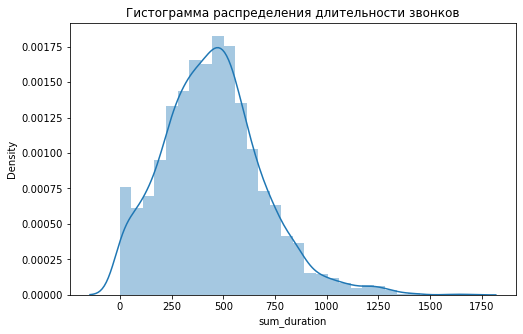

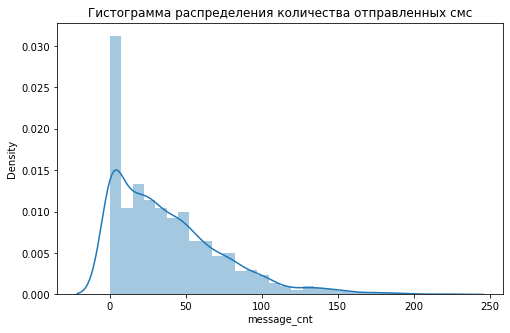

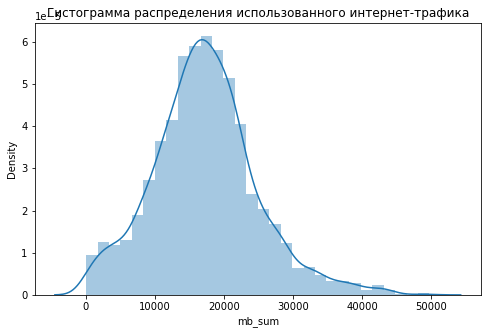

,Параметр,Дисперсия,Стандартное отклонение,Среднее значение,Медиана
0,Длительность звонков,58520.44,241.909978,451.244866,443.0
1,Количество отправленных смс,1306.70,36.148326,38.281269,30.0
2,Количество израсходованных мегабайт,57319598.59,7570.970783,17208.101742,16943.5


In [43]:
d=[]
for z, title, hist in zip(('sum_duration',
                     'message_cnt',
                     'mb_sum'),
                    ('Длительность звонков',
                     'Количество отправленных смс',
                     'Количество израсходованных мегабайт'),
                    ('Гистограмма распределения длительности звонков',
                     'Гистограмма распределения количества отправленных смс',
                     'Гистограмма распределения использованного интернет-трафика')):
    
    
    d.append({'Параметр': title,
              'Дисперсия': parametrs(revenue_users[z])[0],
              'Стандартное отклонение': parametrs(revenue_users[z])[1],
              'Среднее значение': parametrs(revenue_users[z])[2],
              'Медиана': parametrs(revenue_users[z])[3]})
    
    
    plt.figure(figsize=(8, 5))
    sns.distplot(revenue_users[z], bins=30, kde=True)
    plt.title(hist)
    plt.show()

    
    
    
    
pd.DataFrame(d)

Так как мы имеем непрерывную величину, а не дискретную в наборе данных, для визуализации мы будем использовать график распределениия плотности вероятности. Так как при использовании обычной гистограммы можно не получить полное представление о значениях переменной, так как полученная гистограмма будет сильно зависеть от того, как мы разбили множество значений на интервалы.

Для того, чтобы оценить, сколько значений попало в любой интервал, берут два значения и ищут площадь плотностной гистограммы между ними. Полученное число и будет оценкой количества значений, попавших в интервал.

Исходя из графиков, средний размер израсходованых минут в месяц пользователем составляет около 500 минут. Значения распределены нормально есть небольшая скошенность вправо. Найдем какие значения являются аномалиями.

Для большинства распределений верно правило трёх стандартных отклонений, или правило трёх сигм. Оно гласит — практически все
значения (около 99% находятся в промежутке `(μ − 3σ,μ + 3σ)`. Это правило позволяет не только находить интервал, в который наверняка попадут практически все значения интересующей нас переменной, но и искать значения вне этого интервала — часто их
называют выбросами.

<div class="alert alert-info"> <b>Комментарий студента:  </b> 
    Вернула клиентов, которорые не пользовались звонками, смс и интернетом. Наблюдаем большое количество клиентов, которые совсем не пользуются смс сообщениями.
    
 </div>

In [44]:
out_call = mean_call + standard_deviation_call*3
out_call

1176.9748016467108

Клиенты совершающие звонков более 1170 минут в месяц - исключение.

Для смс распределение имеет более скошенный вид. При этом набор данных скошен справо. 
Чтобы понять, в какую сторону скошен датасет, необязательно строить графики. Достаточно взглянуть на метрики локации: медиану и среднее. Помня о том, что медиана в отличие от среднего устойчива к выбросам, легко сделать вывод, что для скошенных вправо данных медиана будет меньше среднего, а для скошенных влево — больше.

In [45]:
out_message = mean_message + standard_deviation_message*3
print('Верхняя граница диапазона израсходованых в месяц смс равна', out_message)
out_internet = mean_internet + standard_deviation_internet*3
print('Верхняя граница диапазона израсходованых в месяц мегабайт равна', out_internet)

Верхняя граница диапазона израсходованых в месяц смс равна 146.72624616694262
Верхняя граница диапазона израсходованых в месяц мегабайт равна 39921.01409047938


Основная часть - 99 % пользователей расходуют не более 150 смс, 1170 минут разговоров и 40 Гб интернета. Большая часть из этой аудитории расходуют в от 300 до 600 минут, от 0 до 50 смс и от 10 до 25 Гб интернета. 

**Сделаем разбивку по тарифам и сравним распределения значений расхода звонков, смс и мегабайт интернета ежемесячно.**

In [46]:
#d=[]
#d1=[]

#for z, title, hist in zip(('sum_duration',
#                     'message_cnt',
#                     'mb_sum'),
#                    ('Длительность звонков',
#                     'Количество отправленных смс',
#                     'Количество израсходованных мегабайт'),
#                    ('Гистограмма распределения длительности звонков',
#                     'Гистограмма распределения количества отправленных смс',
#                     'Гистограмма распределения использованного интернет-трафика')):
    
#    d.append({'Параметр': title,
#              'Дисперсия': parametrs(revenue_users.loc[revenue_users[z] != 0].query('tariff == "ultra"')[z])[0],
#              'Стандартное отклонение': parametrs(revenue_users.loc[revenue_users[z] != 0].query('tariff == "ultra"')[z])[1],
#              'Среднее значение': parametrs(revenue_users.loc[revenue_users[z] != 0].query('tariff == "ultra"')[z])[2],
#              'Медиана': parametrs(revenue_users.loc[revenue_users[z] != 0].query('tariff == "smart"')[z])[3]})
#    d1.append({'Параметр': title,
#              'Дисперсия': parametrs(revenue_users.loc[revenue_users[z] != 0].query('tariff == "smart"')[z])[0],
#              'Стандартное отклонение': parametrs(revenue_users.loc[revenue_users[z] != 0].query('tariff == "smart"')[z])[1],
#              'Среднее значение': parametrs(revenue_users.loc[revenue_users[z] != 0].query('tariff == "smart"')[z])[2], 
#               'Медиана': parametrs(revenue_users.loc[revenue_users[z] != 0].query('tariff == "smart"')[z])[3]})
    
#    plt.figure(figsize=(10, 5))
    
#    sns.kdeplot(revenue_users.loc[revenue_users[z] != 0].query('tariff == "smart"')[z], color='red')
#    sns.kdeplot(revenue_users.loc[revenue_users[z] != 0].query('tariff == "ultra"')[z])
#    plt.title(hist)
#    plt.legend(labels=['Для тарифа Смарт', 'Для тарифа Ультра'])
#    plt.show()

    
    
    
#print('Показатели для выборки пользователей тарифа Ультра:')    
#display(pd.DataFrame(d))
#print('Показатели для выборки пользователей тарифа Смарт:') 
#display(pd.DataFrame(d1))

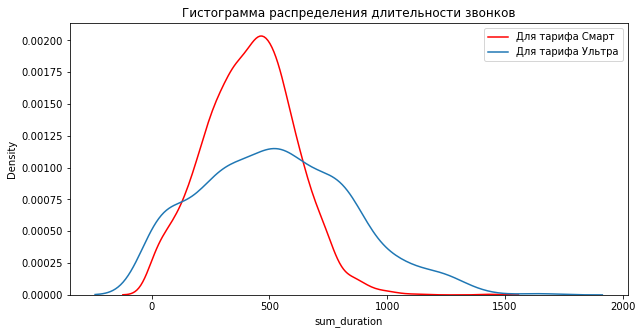

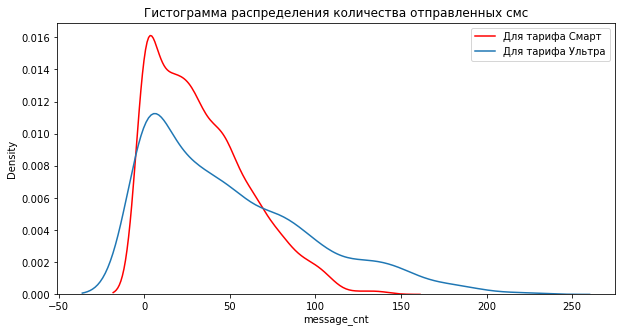

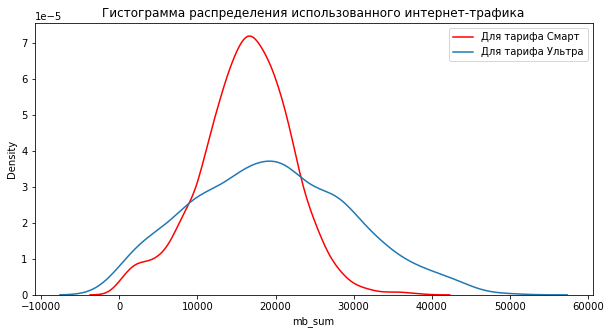

Показатели для выборки пользователей тарифа Ультра:


,Параметр,Дисперсия,Стандартное отклонение,Среднее значение,Медиана
0,Длительность звонков,1.008736e+05,317.606098,526.623350,422.0
1,Количество отправленных смс,2.285270e+03,47.804457,49.363452,28.0
2,Количество израсходованных мегабайт,1.017514e+08,10087.190383,19469.302538,16507.0


Показатели для выборки пользователей тарифа Смарт:


,Параметр,Дисперсия,Стандартное отклонение,Среднее значение,Медиана
0,Длительность звонков,36219.32,190.313730,417.934948,422.0
1,Количество отправленных смс,796.81,28.227876,33.384029,28.0
2,Количество израсходованных мегабайт,34462559.48,5870.482049,16208.872140,16507.0


In [47]:
d=[]
d1=[]

for z, title, hist in zip(('sum_duration',
                     'message_cnt',
                     'mb_sum'),
                    ('Длительность звонков',
                     'Количество отправленных смс',
                     'Количество израсходованных мегабайт'),
                    ('Гистограмма распределения длительности звонков',
                     'Гистограмма распределения количества отправленных смс',
                     'Гистограмма распределения использованного интернет-трафика')):
    
    d.append({'Параметр': title,
              'Дисперсия': parametrs(revenue_users.query('tariff == "ultra"')[z])[0],
              'Стандартное отклонение': parametrs(revenue_users.query('tariff == "ultra"')[z])[1],
              'Среднее значение': parametrs(revenue_users.query('tariff == "ultra"')[z])[2],
              'Медиана': parametrs(revenue_users.query('tariff == "smart"')[z])[3]})
    d1.append({'Параметр': title,
              'Дисперсия': parametrs(revenue_users.query('tariff == "smart"')[z])[0],
              'Стандартное отклонение': parametrs(revenue_users.query('tariff == "smart"')[z])[1],
              'Среднее значение': parametrs(revenue_users.query('tariff == "smart"')[z])[2], 
               'Медиана': parametrs(revenue_users.query('tariff == "smart"')[z])[3]})
    
    plt.figure(figsize=(10, 5))
    
    sns.kdeplot(revenue_users.query('tariff == "smart"')[z], color='red')
    sns.kdeplot(revenue_users.query('tariff == "ultra"')[z])
    plt.title(hist)
    plt.legend(labels=['Для тарифа Смарт', 'Для тарифа Ультра'])
    plt.show()

    
    
    
print('Показатели для выборки пользователей тарифа Ультра:')    
display(pd.DataFrame(d))
print('Показатели для выборки пользователей тарифа Смарт:') 
display(pd.DataFrame(d1))

***Вывод:***

Итак сравнив пользователей тарифов Ультра и Смарт, можно увидеть, что пользователи Смарт тратят меньше времени на разговоры, отправляют меньше смс, и в целом диапазон расходованиия интернет трафика смещенн в отрицательную сторону по отношению к распределению тарифа Ультра. Хотя пользователей, которые тратят в месяц менее 10 Гб среди пользователей Ультра больше, возможно потому, что данный тариф преобретается для конкретных целей - например преимущественно для звонков. Максимальные значения так же больше у тарифа Ультра.

* Основная часть пользователей тарифа Смарт расходует от 250 до 700 минут в месяц, тарифа Ультра от 250 до 1000 минут;
* пользователи тарифа Смарт расходуют от 0 до 50 смс в месяц, тарифа Ультра от 0 до 100 смс;
* пользователи тарифа Смарт расходуют от 10 до 25 Гб в месяц, тарифа Ультра от 5 до 35 Гб.

### Шаг 4.
### Проверить гипотезы

* **Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются**



Объявим нулевую гипотезу как: «разницы между средней выручкой пользователей тарифов `Ультра` и `Смарт` нет, исследуемые параметры равны», альтернатиная гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Мы используем методы проверки гипотезы о равенстве двух генеральных совокупностей. Только обозначим, что наш массив данных представляет собой выборку из генеральной совокупности, т.к. мы имеем данные только за один год.

Выборочные совокупности не зависят друг от друга и выборочные средние должны быть нормально распределены - условия, которые необходимы для возможности применения t-теста. Первое условие соблюдено, а второе условие не препятстви. Благодаря ЦПТ, если размер выборки составляет хотя бы несколько десятков значений, выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности. Это утверждение верно, даже если сама генеральная совокупность не распределена нормально.

Еще одно условие дисперсии рассматриваемых совокупностей должны быть равны. По умолчанию параметр equal_var принимает значение True: дисперсии считаются равными и тест объединяет обе выборки в одну, чтобы эту дисперсию поточнее оценить.
При этом если выборки достаточно велики (30 и больше значений) и равны по размеру между собой, такой подход оправдан: симуляции, проведённые учёными, показывают, что даже если дисперсии на самом деле не равны, то тест редко ошибается.


In [48]:
print(len(revenue_users.query('tariff == "smart"')['revenue_user']))
print(len(revenue_users.query('tariff == "ultra"')['revenue_user']))

2229
985


Выборки хоть и отличаются по размеру, но достаточно большие, чтобы можно было проводить тест.

Выборки не равны между собой и содержат разные условия тарифов, поэтому дисперсии выборок вероятно не равны. Выборки достаточно велики, чтобы и по отдельности точно оценить дисперсию каждой генеральной совокупности. Их объединение не сильно увеличит точность оценки дисперсии. А если дисперсии и правда разные, то такое объединение только исказит картину.

In [49]:
print('Дисперсия', np.var(revenue_users.query('tariff == "smart"')['revenue_user'], ddof=1))
print('Дисперсия', np.var(revenue_users.query('tariff == "ultra"')['revenue_user'], ddof=1))

Дисперсия 669785.7080064153
Дисперсия 141516.74507861698


In [50]:
alpha = 0.05
# если p-value окажется меньше него - отвергнем гипотезу

In [51]:
sample_1 = revenue_users.query('tariff == "smart"')['revenue_user']
sample_2 = revenue_users.query('tariff == "ultra"')['revenue_user']

In [52]:
results = st.ttest_ind(
    sample_1, 
    sample_2, 
    equal_var = False)

print('p-значение:', results.pvalue)

p-значение: 4.2606313931076085e-250


In [53]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Отвергаем нулевую гипотезу


In [54]:
probability = round(results.pvalue*100, 0)

In [55]:
print('Значение p-value показывает: вероятность случайно получить такое или большее \
различие близится к', probability, '% и можно делать вывод о    значимом различии между \
средней выручкой в месяц среди пользователями тарифов Smart и Ultra')

Значение p-value показывает: вероятность случайно получить такое или большее различие близится к 0.0 % и можно делать вывод о    значимом различии между средней выручкой в месяц среди пользователями тарифов Smart и Ultra


**Вывод**

Мы не можем опровергнуть поставленную нами гипотезу, о том, что средняя месячная выручка пользователей тарифов «Ультра» и «Смарт» различаются. Различия между средней выручкой в месяц среди пользователями тарифов Smart и Ultra существенны.

* **Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Для этого, нам необходимо в наш датасет добавитть город проживания пользователя.

In [56]:
revenue_users = revenue_users.merge(users[['user_id', 'city']])

In [57]:
print(len(revenue_users.query('city == "Москва"')))
print(len(revenue_users.query('city != "Москва"')))

611
2603


Размер выборок существенно отличается, поэтому предположим, что дисперсии генеральных совокупностей не равны. Зададим параметр *equal_var = False*.

In [58]:
print('Дисперсия', np.var(revenue_users.query('city == "Москва"')['revenue_user'], ddof=1))
print('Дисперсия', np.var(revenue_users.query('city != "Москва"')['revenue_user'], ddof=1))

Дисперсия 565636.4670118855
Дисперсия 654137.6285218048


Объявим нулевую гипотезу как: «разницы между средней выручкой пользователей из Москвы и из регионов нет, исследуемые параметры равны», альтернатиная гипотеза - средняя выручка пользователей из Москвы и из регионов различаются.

In [59]:
sample_3 = revenue_users.query('city == "Москва"')['revenue_user']
sample_4 = revenue_users.query('city != "Москва"')['revenue_user']

In [60]:
alpha = 0.05
# если p-value окажется меньше него - отвергнем гипотезу

In [61]:
results2 = st.ttest_ind(
    sample_3, 
    sample_4, 
    equal_var = False)

print('p-значение:', results2.pvalue)

p-значение: 0.5257376663729298


In [62]:
if results2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Не получилось отвергнуть нулевую гипотезу


In [63]:
probability2 = round(results2.pvalue*100, 0)
print('Значение p-value показывает: вероятность случайно получить такое или большее \
различие равно почти', probability2, '%, хотя средняя выручка пользователей разных городов \
и не одинаковы. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии \
между средним размером выручки пользователей Москвы и регионов')

Значение p-value показывает: вероятность случайно получить такое или большее различие равно почти 53.0 %, хотя средняя выручка пользователей разных городов и не одинаковы. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средним размером выручки пользователей Москвы и регионов


**Вывод**

Мы не будем утверждать, что средняя выручка пользователей из Москвы и из регионов различаются.

Для того, чтобы ответить на вопрос какой тариф лучше, нам нужно проверить одностороннюю гипотезу. Двустронняя гипотеза может только ответить на вопрос равны ли средние генеральных совокупностей, либо не равны.

Обозначим нулевую гипотезу, как средняя выручка с клиентов - пользователей двух тарифов, равна. И альтернативная гипотеза - средняя выручка в месяц пользователей тарифа Ультра больше, чем средняя выручка пользователей тарифа Смарт.

In [64]:
results3 = st.ttest_ind(
    sample_1, 
    sample_2, 
    equal_var = False)

print('p-значение:', results.pvalue/2)

p-значение: 2.1303156965538042e-250


In [65]:
# отвергаем гипотезу только тогда, когда выборочное среднее выборки с пользователями тарифа Ультра значимо превышает
if (results.pvalue / 2 < alpha) and (sample_2.mean() > sample_1.mean()):                 # выборочное среднее выборки
    print("Отвергаем нулевую гипотезу")                                                  # с пользователями тарифа Смарт
else:
    print("Не отвергаем нулевую гипотезу") 


Отвергаем нулевую гипотезу


Итак можно сделать вывод, что пользователи тарифа Ультра приносят компании в среднем больше ежемесячной выручки. Следовательно тариф Ультра лучше.

### Шаг 5.
### Общий вывод

Проанализировав поведение клиентов мы сделали вывод, что пользователи тарифа смарт расходуют меньше минут разговора, меньше смс и интернет трафика. Для того, чтобы сделать вывод какой тариф лучше нужно изучить, какой из тарифов приносит в среднем больший доход для компании. Для этого мы проверили следующие гипотезы:
1. Средняя выручка пользователей тарифа «Ультра» и «Смарт» различаются;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
3. Средняя выручка пользователей тарифа «Ультра» больше чем средняя выручка пользователей тарифа «Смарт».

* Различия между средней выручкой в месяц среди пользователями тарифов Smart и Ultra существенны, поэтому мы принимаем первую гипотезу.
* Мы не будем утверждать, что средняя выручка пользователей из Москвы и из регионов различаются. Отвергаем вторую гипотезу.
* Пользователи тарифа Ультра приносят компании в среднем больше ежемесячной выручки. Следовательно тариф Ультра лучше.
